# Variational Message Passing for Estimation

ForneyLab comes with support for variational message passing (VMP) (Dauwels, 2007):

- Dauwels J., On variational message passing on factor graphs, IEEE Intl symposium on information theory, Nice (France), June 2007

In this demo we illustrate VMP by estimating the mean and precision (inverse variance) of a Gaussian distribution from samples. The model is defined as:

\begin{align*}
    m   &\sim \mathcal{N}(0, 100)\\
    w   &\sim \mathcal{G}am(0.01, 0.01)\\
    y_i &\sim \mathcal{N}(m, w^{-1}) \,\,\text{for}\,\, i=1,\ldots,n
\end{align*}

Variational inference approximates the exact posterior over $m$ and $w$ by a factorized posterior distribution. We minimize the KL divergence between the factorized posterior distribution and the exact posterior through variational message passing.

Let's first generate a data set

In [2]:
# Generate toy data set
n = 5

m_data = 3.0
w_data = 4.0
y_data = sqrt(1/w_data)*randn(n) .+ m_data;

# Model specification

In [3]:
using(ForneyLab)

g = FactorGraph()

# Priors
@RV m ~ GaussianMeanVariance(0.0, 100.0)
@RV w ~ Gamma(0.01, 0.01)

# Observarion model
y = Vector{Variable}(undef, n)
for i = 1:n
    @RV y[i] ~ GaussianMeanPrecision(m, w)
    placeholder(y[i], :y, index=i)
end

# Debug dump for visualisation frontend

It is possible to use model specification and inference results to inspect algorithm performance in FactorGraphViewer visualsation frontend. Visuaslisation frontend will show actual graph structure, passed messages, score heatmap etc. in a nice UI.

To create a static dump we can use `makeDump` function which accepts an instance of `FactorGraph` object. Later we shall use this static dump during our inference steps and free energy computation.

In [5]:
algorithm_dump = makeDump(g);

# Algorithm generation

With the model defined, we can now specify a **factorized posterior distribution**

$$\begin{align*}
    q(m, w) = q(m)\times q(w)
\end{align*}$$

through the `PosteriorFactorization()` constructor. All variables that are deterministically linked to the argument variables (e.g. through a `+` or `=` relation) automatically become part of a single posterior factor. We can also inspect the subgraph corresponding to a posterior factor with the `ForneyLab.draw()` function.

In [6]:
# Specify posterior factorization
q = PosteriorFactorization(m, w, ids=[:M, :W])

# Inspect the subgraph for m
ForneyLab.draw(q.posterior_factors[:M])

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (20200629.0846)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7978885483401741212 -->
 
 7978885483401741212 
 
 = 
 equ_m_2 
 
<!-- 8084901489819187122 -->
 
 8084901489819187122 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 7978885483401741212--8084901489819187122 -->
 
 7978885483401741212--8084901489819187122 
 
 m 
 2 m 
 1 1 
 
<!-- 942294051312613177 -->
 
 942294051312613177 
 
 = 
 equ_m_1 
 
<!-- 7978885483401741212--942294051312613177 -->
 
 7978885483401741212--942294051312613177 
 
 m 
 3 3 
 2 2 
 
<!-- 14392341604533674024 -->
 
 14392341604533674024 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5756866628314860012 -->
 
 5756866628314860012 
 
 = 
 equ_m_3 
 
<!-- 5756866628314860012--7978885483401741212 -->
 
 5756866628314860012--7978885483401741212 
 
 m 
 3 3 
 2 2 
 
<!-- 12176719349325885133 -->
 
 12176719349325885133 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 5756866628314860012--12176719349325885133 -->
 
 5756866628314860012--12176719349325885133 
 
 m 
 2 m 
 1 1 
 
<!-- 154783652302360351 -->
 
 154783652302360351 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 942294051312613177--14392341604533674024 -->
 
 942294051312613177--14392341604533674024 
 
 m 
 2 m 
 2 2 
 
<!-- 1151956397718470575 -->
 
 1151956397718470575 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 942294051312613177--1151956397718470575 -->
 
 942294051312613177--1151956397718470575 
 
 m 
 1 out 
 1 1 
 
<!-- 15696495718017713171 -->
 
 15696495718017713171 
 
<!-- 1151956397718470575--15696495718017713171 -->
 
 1151956397718470575--15696495718017713171 
 
 1 out 
 2 m 
 
<!-- 16084182534597816305 -->
 
 16084182534597816305 
 
<!-- 1151956397718470575--16084182534597816305 -->
 
 1151956397718470575--16084182534597816305 
 
 1 out 
 3 v 
 
<!-- 15630560754196741771 -->
 
 15630560754196741771 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 3031505746528128488 -->
 
 3031505746528128488 
 
 = 
 equ_m_4 
 
<!-- 3031505746528128488--5756866628314860012 -->
 
 3031505746528128488--5756866628314860012 
 
 m 
 3 3 
 2 2 
 
<!-- 3031505746528128488--154783652302360351 -->
 
 3031505746528128488--154783652302360351 
 
 m 
 2 m 
 1 1 
 
<!-- 3031505746528128488--15630560754196741771 -->
 
 3031505746528128488--15630560754196741771 
 
 m 
 2 m 
 3 3 
 
<!-- 3011834740468711642 -->
 
 3011834740468711642 
 
<!-- 3011834740468711642--14392341604533674024 -->
 
 3011834740468711642--14392341604533674024 
 
 3 w 
 2 2 
 
<!-- 17195435265351351158 -->
 
 17195435265351351158 
 
<!-- 17195435265351351158--8084901489819187122 -->
 
 17195435265351351158--8084901489819187122 
 
 3 w 
 1 1 
 
<!-- 9576810255590556558 -->
 
 9576810255590556558 
 
<!-- 9576810255590556558--8084901489819187122 -->
 
 9576810255590556558--8084901489819187122 
 
 1 out 
 1 out 
 
<!-- 6998236467348028853 -->
 
 6998236467348028853 
 
<!-- 6998236467348028853--154783652302360351 -->
 
 6998236467348028853--154783652302360351 
 
 3 w 
 1 1 
 
<!-- 6998236467348028853--15630560754196741771 -->
 
 6998236467348028853--15630560754196741771 
 
 3 w 
 3 3 
 
<!-- 4759539855010716359 -->
 
 4759539855010716359 
 
<!-- 4759539855010716359--14392341604533674024 -->
 
 4759539855010716359--14392341604533674024 
 
 1 out 
 1 out 
 
<!-- 16338636701735854572 -->
 
 16338636701735854572 
 
<!-- 16338636701735854572--15630560754196741771 -->
 
 16338636701735854572--15630560754196741771 
 
 1 out 
 1 out 
 
<!-- 17237630624153727307 -->
 
 17237630624153727307 
 
<!-- 17237630624153727307--154783652302360351 -->
 
 17237630624153727307--154783652302360351 
 
 1 out 
 1 out 
 
<!-- 8413056699034086679 -->
 
 8413056699034086679 
 
<!-- 8413056699034086679--12176719349325885133 -->
 
 8413056699034086679--12176719349325885133 
 
 1 out 
 1 out 
 
<!-- 17368763584104746066 -->
 
 17368763584104746066 
 
<!-- 17368763584104746066

In [7]:
# Inspect the subgraph for W
ForneyLab.draw(q.posterior_factors[:W])

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (20200629.0846)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17195435265351351158 -->
 
 17195435265351351158 
 
 = 
 equ_w_2 
 
<!-- 8084901489819187122 -->
 
 8084901489819187122 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 17195435265351351158--8084901489819187122 -->
 
 17195435265351351158--8084901489819187122 
 
 w 
 3 w 
 1 1 
 
<!-- 3011834740468711642 -->
 
 3011834740468711642 
 
 = 
 equ_w_1 
 
<!-- 17195435265351351158--3011834740468711642 -->
 
 17195435265351351158--3011834740468711642 
 
 w 
 3 3 
 2 2 
 
<!-- 6998236467348028853 -->
 
 6998236467348028853 
 
 = 
 equ_w_4 
 
<!-- 154783652302360351 -->
 
 154783652302360351 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 6998236467348028853--154783652302360351 -->
 
 6998236467348028853--154783652302360351 
 
 w 
 3 w 
 1 1 
 
<!-- 17368763584104746066 -->
 
 17368763584104746066 
 
 = 
 equ_w_3 
 
<!-- 6998236467348028853--17368763584104746066 -->
 
 6998236467348028853--17368763584104746066 
 
 w 
 3 3 
 2 2 
 
<!-- 15630560754196741771 -->
 
 15630560754196741771 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 6998236467348028853--15630560754196741771 -->
 
 6998236467348028853--15630560754196741771 
 
 w 
 3 w 
 3 3 
 
<!-- 12176719349325885133 -->
 
 12176719349325885133 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 17368763584104746066--17195435265351351158 -->
 
 17368763584104746066--17195435265351351158 
 
 w 
 3 3 
 2 2 
 
<!-- 17368763584104746066--12176719349325885133 -->
 
 17368763584104746066--12176719349325885133 
 
 w 
 3 w 
 1 1 
 
<!-- 16322183077109201816 -->
 
 16322183077109201816 
 
 Gam 
 gamma_1 
 
<!-- 3011834740468711642--16322183077109201816 -->
 
 3011834740468711642--16322183077109201816 
 
 w 
 1 out 
 1 1 
 
<!-- 14392341604533674024 -->
 
 14392341604533674024 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3011834740468711642--14392341604533674024 -->
 
 3011834740468711642--14392341604533674024 
 
 w 
 3 w 
 2 2 
 
<!-- 17191087848151779070 -->
 
 17191087848151779070 
 
<!-- 16322183077109201816--17191087848151779070 -->
 
 16322183077109201816--17191087848151779070 
 
 1 out 
 3 b 
 
<!-- 13613761595830469675 -->
 
 13613761595830469675 
 
<!-- 16322183077109201816--13613761595830469675 -->
 
 16322183077109201816--13613761595830469675 
 
 1 out 
 2 a 
 
<!-- 942294051312613177 -->
 
 942294051312613177 
 
<!-- 942294051312613177--14392341604533674024 -->
 
 942294051312613177--14392341604533674024 
 
 2 m 
 2 2 
 
<!-- 7978885483401741212 -->
 
 7978885483401741212 
 
<!-- 7978885483401741212--8084901489819187122 -->
 
 7978885483401741212--8084901489819187122 
 
 2 m 
 1 1 
 
<!-- 9576810255590556558 -->
 
 9576810255590556558 
 
<!-- 9576810255590556558--8084901489819187122 -->
 
 9576810255590556558--8084901489819187122 
 
 1 out 
 1 out 
 
<!-- 5756866628314860012 -->
 
 5756866628314860012 
 
<!-- 5756866628314860012--12176719349325885133 -->
 
 5756866628314860012--12176719349325885133 
 
 2 m 
 1 1 
 
<!-- 4759539855010716359 -->
 
 4759539855010716359 
 
<!-- 4759539855010716359--14392341604533674024 -->
 
 4759539855010716359--14392341604533674024 
 
 1 out 
 1 out 
 
<!-- 16338636701735854572 -->
 
 16338636701735854572 
 
<!-- 16338636701735854572--15630560754196741771 -->
 
 16338636701735854572--15630560754196741771 
 
 1 out 
 1 out 
 
<!-- 17237630624153727307 -->
 
 17237630624153727307 
 
<!-- 17237630624153727307--154783652302360351 -->
 
 17237630624153727307--154783652302360351 
 
 1 out 
 1 out 
 
<!-- 8413056699034086679 -->
 
 8413056699034086679 
 
<!-- 8413056699034086679--12176719349325885133 -->
 
 8413056699034086679--12176719349325885133 
 
 1 out 
 1 out 
 
<!-- 3031505746528128488 -->
 
 3031505746528128488 
 
<!-- 3031505746528128488--154783652302360351 -->
 
 3031505746528128488--154783652302360351 
 
 2 m 
 1 1 
 
<!-- 30315057465

In [10]:
# Build the variational update algorithms for each posterior factor
algo = messagePassingAlgorithm(free_energy = true)


# Generate source code for the algorithms
# algorithmSourceCode function accepts optional debug argument which can be used to setup a debug environment for the algorithm. 
# In this case it would be possible to use static dump object during inference steps and free energy computation.
source_code = algorithmSourceCode(algo, free_energy=true, debug = true)

# And inspect the algorithm code
println(source_code)

begin

function stepM!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 10); dump::Union{GraphDump, Nothing} = nothing)


push!(dump.steps[end].messages, Vector{MessageData}())

push!(dump.steps[end].marginals, Vector{MarginalData}())
messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=0.0), ProbabilityDistribution(Univariate, PointMass, m=100.0))

pushMessage!(dump, "gaussianmeanvariance_1_equ_m_1", "forward", messages[1])
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][4]), nothing, marginals[:w])

pushMessage!(dump, "gaussianmeanprecision_4_equ_m_4", "forward", messages[2])
messages[3] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][5]), nothing, marginals[:w])

pushMessage!(dump, "gaussianmeanprecision_5_equ_m_4", "forward", messages[3])
messages[4] = ruleSPEqualityGaussian(messages[2], nothing, messages[3

Note that the algorithm now contains two `step!()` functions: one for each posterior factor. This is because variational message passing is an iterative algorithm, where `stepM!()` requires the marginal from `marginals[:w]` and `stepW!()` requires `marginals[:m]`. This requires us to initialize the marginals before we start the inference. The marginals argument allows us to pass an initial dictionary of marginals. Upon execution, this dictionary is updated in-place with the newly computed outcomes.

Additionally, we can also automatically generate code that evaluates the free energy by passing `free_energy=true` to `algorithmSourceCode` function. This yields a model-specific `freeEnergy()` function that accepts the data and marginals dictionaries.

The free energy can be used to check for convergence or to perform model comparisons.

# Execution

In [11]:
# Load algorithm
eval(Meta.parse(source_code));

As mentioned before, we need to initialize the `marginals` dictionary. After initialization, we iteratively step through the algorithm functions and evaluate the free energy and estimates after each iteration (for visualization purposes).

In [12]:
data = Dict(:y => y_data)

# Initial posterior factors
marginals = Dict(:m => vague(GaussianMeanVariance),
                 :w => vague(Gamma))

n_its = 2*n
F = Vector{Float64}(undef, n_its) # Initialize vector for storing Free energy
m_est = Vector{Float64}(undef, n_its)
w_est = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepM!(data, marginals, dump = algorithm_dump)
    stepW!(data, marginals, dump = algorithm_dump)
    
    # Store free energy
    F[i] = freeEnergy(data, marginals, dump = algorithm_dump)
end
;

# Results
In order to evaluate the approximated solution that we obtained using VMP, we will first solve this same problem using exact inference so that later we can compare them both.

In [16]:
using PyPlot, PyCall, SpecialFunctions 
mlines = pyimport("matplotlib.lines")

# Definition of the normal-gamma distribution
Z(μ₀, κ₀, α₀, β₀) = gamma(α₀)/(β₀^α₀)*(2*π/κ₀)^(0.5) # normalization constant
NG(rμ, rλ, D, μ₀, κ₀, α₀, β₀) = [ (1/Z(μ₀, κ₀, α₀, β₀))*λ^(α₀-0.5)*exp(-(λ/2)*((κ₀*(μ-μ₀)^2)+(2*β₀))) for μ=rμ, λ=rλ ] 

# Calculates posterior distribution using exact inference
function exactPosterior(rμ, rλ, D, μ₀, κ₀, α₀, β₀)
    n = length(D)
    x̄ = sum(D) / n
    μₙ = (κ₀*μ₀ + n*x̄)/(κ₀ + n)
    κₙ = κ₀ + n
    αₙ = α₀ + n/2
    βₙ = β₀ + 0.5*var(D,corrected=false)*n + (κ₀*n*(x̄ - μ₀)^2)/(2*(κ₀+n))
    NG(rμ, rλ, D, μₙ, κₙ, αₙ, βₙ)
end
;

We can now compare both solutions by overlaying them on the same contour plot.

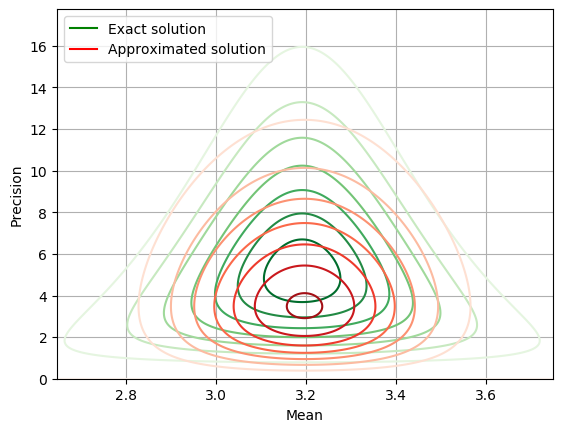

In [17]:
# Define the x and y limits for the contour plot
std_dev_ml = sqrt(var(y_data)/length(y_data))
rμ = range(mean(y_data)-3*std_dev_ml, mean(y_data)+3*std_dev_ml, length=1000)
rτ = range(0, 3(1/var(y_data)), length=1000)

# Plot the solution found using exact inference
contour([μ for μ=rμ, τ=rτ], [τ for μ=rμ, τ=rτ], exactPosterior(rμ, rτ, y_data, 0, 0.01, 0.01, 0.01), cmap="Greens")

# Generate a mesh grid of the approximated solution needed by the contour plot function
normal(x, μ, σ²) = (1/(sqrt(2π*σ²))) * exp.(-(x .- μ).^2 / (2*σ²)) # definition of the Gaussian distribution
Gam(λ, a, b) = (1/factorial(a-1)) * b^a * λ.^(a-1) .* exp.(-b*λ) # definition of the gamma distribution
approx(rμ, rτ, m_μ, v_μ, a_ω, b_ω) = [normal(μ, m_μ, v_μ) * Gam(τ, a_ω, b_ω) for μ=rμ, τ=rτ ]

# Plot the approximated solution found using VMP
contour([μ for μ=rμ, τ=rτ], [τ for μ=rμ, τ=rτ], 
    approx(rμ, rτ, mean(marginals[:m]), var(marginals[:m]), marginals[:w].params[:a], marginals[:w].params[:b]), cmap="Reds")

# Add a legend, a grid and labels to the plot
green_patch = mlines.Line2D([], [], color="green", label="Exact solution")
red_patch = mlines.Line2D([], [], color="red", label="Approximated solution")
legend(handles=[green_patch, red_patch], loc="upper left"); grid(true); xlabel("Mean"); ylabel("Precision");

The plot below shows the convergence of the free energy.

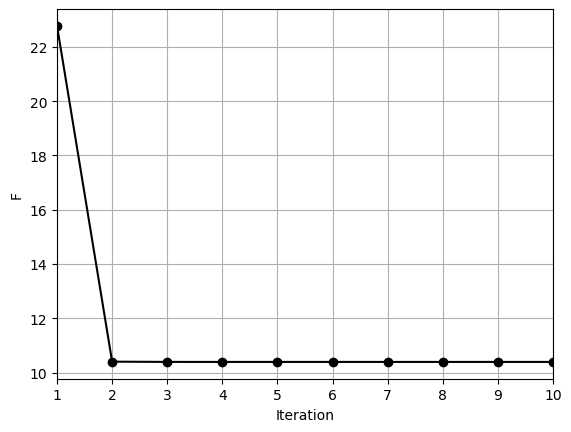

In [18]:
# Plot free energy to check for convergence
plot(1:n_its, F, color="black", marker="o")
grid(true); xlabel("Iteration"); ylabel("F"); xlim([1, length(F)]);

# Debug dump

We can use `save` function to dump inference results and free energy computation into a `.JSON` file which can be used later in a visualisation frontend to inspect algorithm performance

In [19]:
save(algorithm_dump, output = "variational_estimation_iid_gaussian_visualisation.json")